
# Comparison of segmentation and superpixel algorithms

This example compares four popular low-level image segmentation methods.  As
it is difficult to obtain good segmentations, and the definition of "good"
often depends on the application, these methods are usually used for obtaining
an oversegmentation, also known as superpixels. These superpixels then serve as
a basis for more sophisticated algorithms such as conditional random fields
(CRF).


## Felzenszwalb's efficient graph based segmentation
This fast 2D image segmentation algorithm, proposed in [1]_ is popular in the
computer vision community.
The algorithm has a single ``scale`` parameter that influences the segment
size. The actual size and number of segments can vary greatly, depending on
local contrast.

.. [1] Efficient graph-based image segmentation, Felzenszwalb, P.F. and
       Huttenlocher, D.P.  International Journal of Computer Vision, 2004


## Quickshift image segmentation

Quickshift is a relatively recent 2D image segmentation algorithm, based on an
approximation of kernelized mean-shift. Therefore it belongs to the family of
local mode-seeking algorithms and is applied to the 5D space consisting of
color information and image location [2]_.

One of the benefits of quickshift is that it actually computes a
hierarchical segmentation on multiple scales simultaneously.

Quickshift has two main parameters: ``sigma`` controls the scale of the local
density approximation, ``max_dist`` selects a level in the hierarchical
segmentation that is produced. There is also a trade-off between distance in
color-space and distance in image-space, given by ``ratio``.

.. [2] Quick shift and kernel methods for mode seeking,
       Vedaldi, A. and Soatto, S.
       European Conference on Computer Vision, 2008


## SLIC - K-Means based image segmentation

This algorithm simply performs K-means in the 5d space of color information and
image location and is therefore closely related to quickshift. As the
clustering method is simpler, it is very efficient. It is essential for this
algorithm to work in Lab color space to obtain good results.  The algorithm
quickly gained momentum and is now widely used. See [3]_ for details.  The
``compactness`` parameter trades off color-similarity and proximity, as in the
case of Quickshift, while ``n_segments`` chooses the number of centers for
kmeans.

.. [3] Radhakrishna Achanta, Appu Shaji, Kevin Smith, Aurelien Lucchi,
    Pascal Fua, and Sabine Suesstrunk, SLIC Superpixels Compared to
    State-of-the-art Superpixel Methods, TPAMI, May 2012.


## Compact watershed segmentation of gradient images

Instead of taking a color image as input, watershed requires a grayscale
*gradient* image, where bright pixels denote a boundary between regions.
The algorithm views the image as a landscape, with bright pixels forming high
peaks. This landscape is then flooded from the given *markers*, until separate
flood basins meet at the peaks. Each distinct basin then forms a different
image segment. [4]_

As with SLIC, there is an additional *compactness* argument that makes it
harder for markers to flood faraway pixels. This makes the watershed regions
more regularly shaped. [5]_

.. [4] https://en.wikipedia.org/wiki/Watershed_%28image_processing%29

.. [5] Peer Neubert & Peter Protzel (2014). Compact Watershed and
       Preemptive SLIC: On Improving Trade-offs of Superpixel Segmentation
       Algorithms. ICPR 2014, pp 996-1001. :DOI:`10.1109/ICPR.2014.181`
       https://www.tu-chemnitz.de/etit/proaut/publications/cws_pSLIC_ICPR.pdf


Felzenszwalb number of segments: 384
SLIC number of segments: 228
Quickshift number of segments: 869
Watershed number of segments: 48


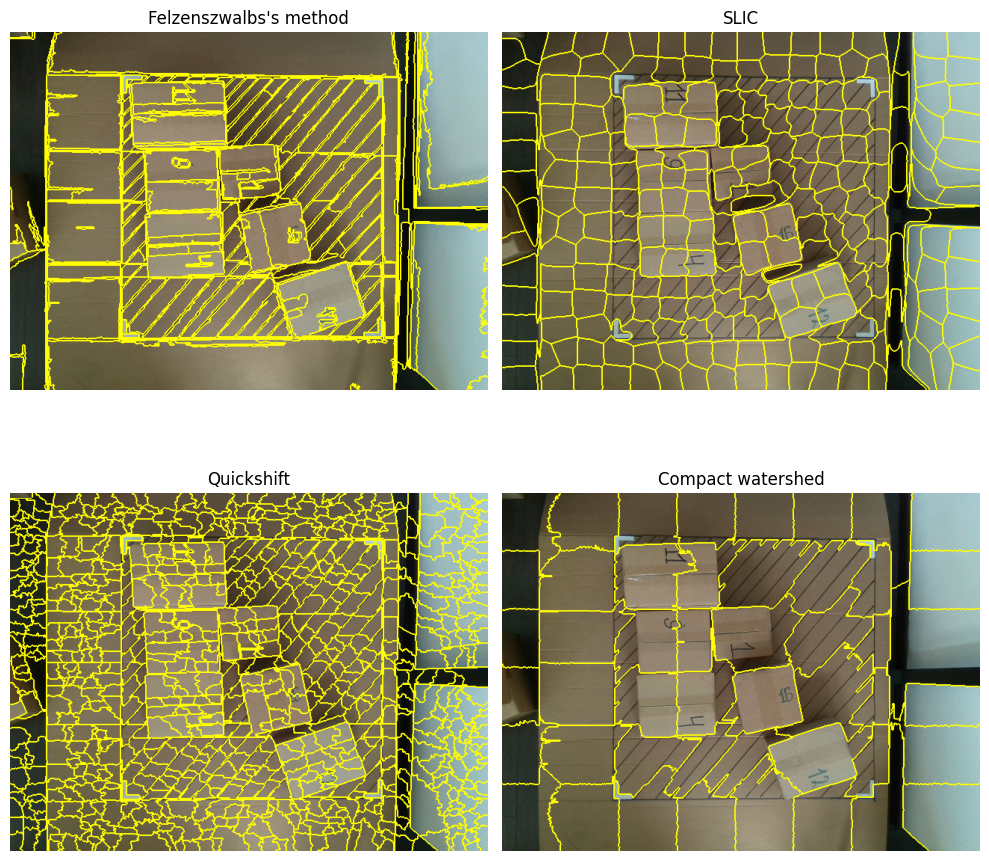

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import skimage
from skimage.data import astronaut
from skimage.color import rgb2gray

from skimage.filters import sobel
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float

img = skimage.io.imread("/Users/dudberoll/PycharmProjects/GaprixCV/data/depth_005_Color.png")
# img = img_as_float(astronaut()[::2, ::2])


segments_fz = felzenszwalb(img, scale=100, sigma=0.5, min_size=50)
segments_slic = slic(img, n_segments=250, compactness=10, sigma=3, start_label=1)
segments_quick = quickshift(img, kernel_size=3, max_dist=6, ratio=0.5)
gradient = sobel(rgb2gray(img))
segments_watershed = watershed(gradient, markers=50, compactness=0.002)

print(f'Felzenszwalb number of segments: {len(np.unique(segments_fz))}')
print(f'SLIC number of segments: {len(np.unique(segments_slic))}')
print(f'Quickshift number of segments: {len(np.unique(segments_quick))}')
print(f'Watershed number of segments: {len(np.unique(segments_watershed))}')

fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

ax[0, 0].imshow(mark_boundaries(img, segments_fz))
ax[0, 0].set_title("Felzenszwalbs's method")
ax[0, 1].imshow(mark_boundaries(img, segments_slic))
ax[0, 1].set_title('SLIC')
ax[1, 0].imshow(mark_boundaries(img, segments_quick))
ax[1, 0].set_title('Quickshift')
ax[1, 1].imshow(mark_boundaries(img, segments_watershed))
ax[1, 1].set_title('Compact watershed')

for a in ax.ravel():
    a.set_axis_off()

plt.tight_layout()
plt.show()

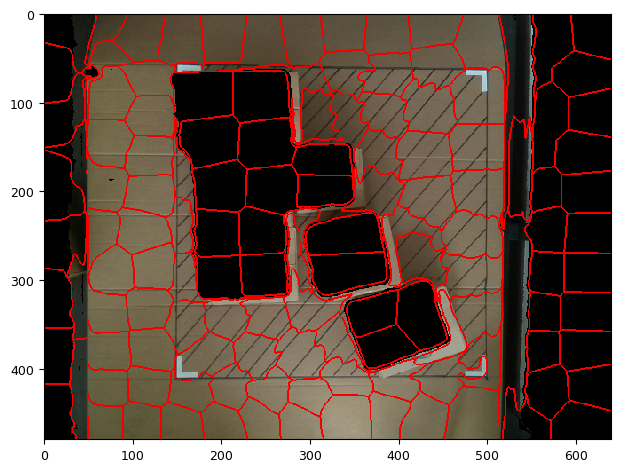

In [40]:
import skimage.util
img = skimage.io.imread("/Users/dudberoll/PycharmProjects/GaprixCV/original.png")
segments_slic = slic(img, n_segments=150, compactness=10, sigma=3, start_label=1)
skimage.io.imshow(mark_boundaries(img, segments_slic, (245/255,0,0)))
original_segmented = mark_boundaries(img, segments_slic, (245/255, 0, 0))
original_segmented = skimage.util.img_as_ubyte(original_segmented)
skimage.io.imsave("/Users/dudberoll/PycharmProjects/GaprixCV/original_segmented.png", original_segmented)

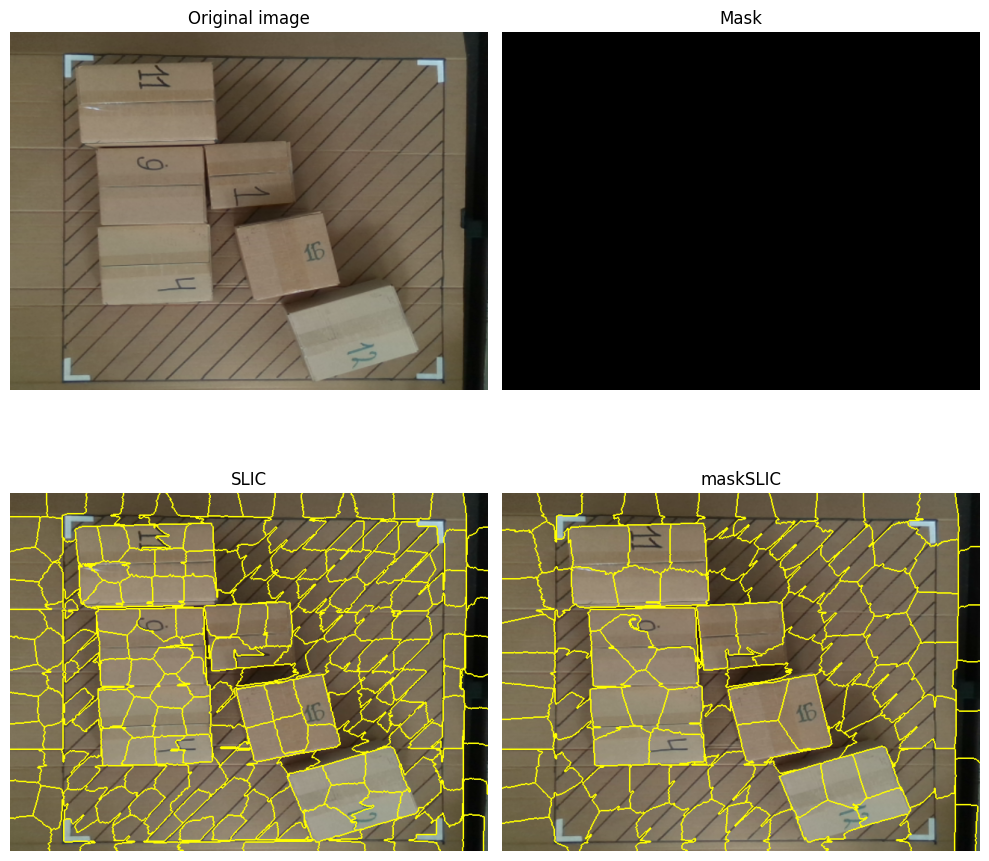

In [4]:
import matplotlib.pyplot as plt

from skimage import data
from skimage import color
from skimage import morphology
from skimage import segmentation

# Input data
img = skimage.io.imread("/Users/dudberoll/PycharmProjects/GaprixCV/depth_005_Color_cropped.png")

# Compute a mask
lum = color.rgb2gray(img)
mask = morphology.remove_small_holes(
    morphology.remove_small_objects(lum < 0.7, 500), 500
)

mask = morphology.opening(mask, morphology.disk(3))

# SLIC result
slic = segmentation.slic(img, n_segments=200, start_label=1)

# maskSLIC result
m_slic = segmentation.slic(img, n_segments=100, mask=mask, start_label=1)

# skimage.io.imsave(m_slic)
# Display result
fig, ax_arr = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10, 10))
ax1, ax2, ax3, ax4 = ax_arr.ravel()

ax1.imshow(img)
ax1.set_title('Original image')

ax2.imshow(mask, cmap='gray')
ax2.set_title('Mask')

ax3.imshow(segmentation.mark_boundaries(img, slic))
ax3.contour(mask, colors='red', linewidths=1)
ax3.set_title('SLIC')

ax4.imshow(segmentation.mark_boundaries(img, m_slic))
ax4.contour(mask, colors='red', linewidths=1)
ax4.set_title('maskSLIC')

for ax in ax_arr.ravel():
    ax.set_axis_off()

plt.tight_layout()
plt.show()

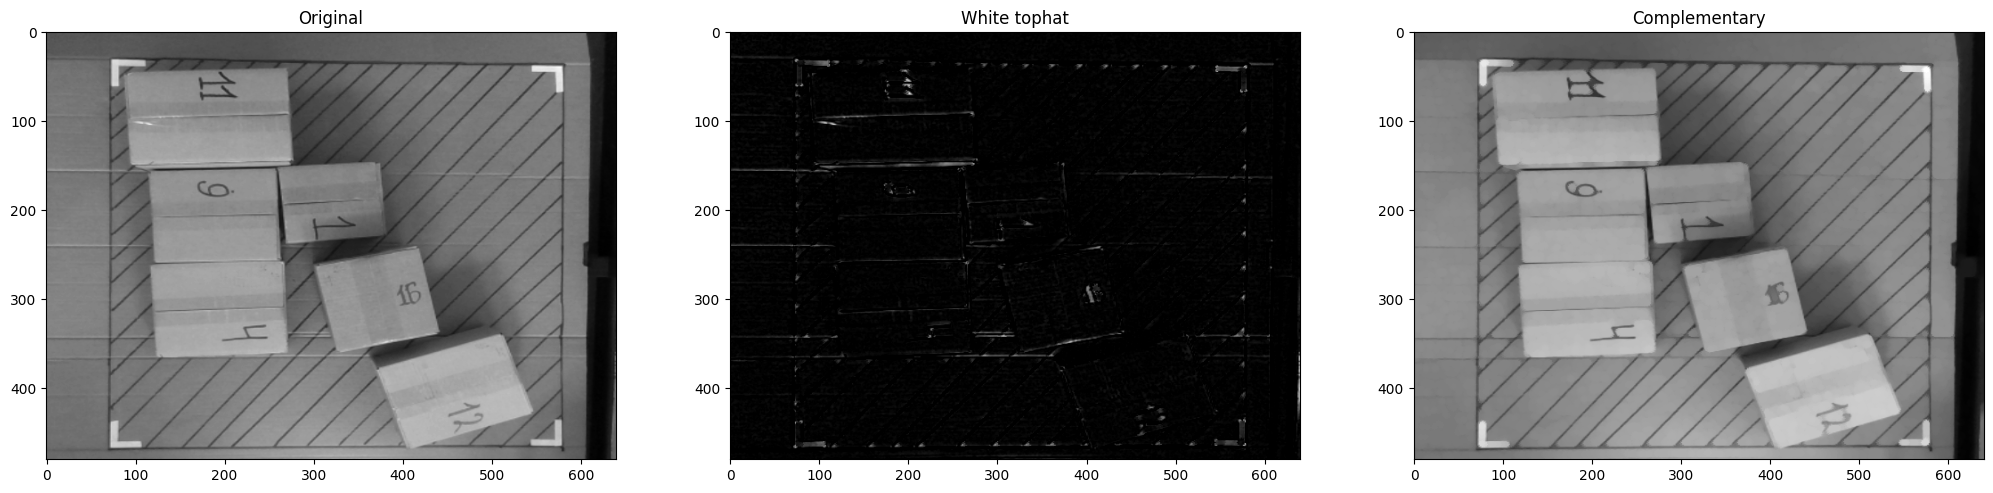

In [10]:
import matplotlib.pyplot as plt

from skimage import color, morphology

image = color.rgb2gray(skimage.io.imread("/Users/dudberoll/PycharmProjects/GaprixCV/depth_005_Color_cropped.png"))

footprint = morphology.disk(3)
res = morphology.white_tophat(image, footprint)

fig, ax = plt.subplots(ncols=3, figsize=(25, 16))
ax[0].set_title('Original')
ax[0].imshow(image, cmap='gray')
ax[1].set_title('White tophat')
ax[1].imshow(res, cmap='gray')
ax[2].set_title('Complementary')
ax[2].imshow(image - res, cmap='gray')

plt.show()

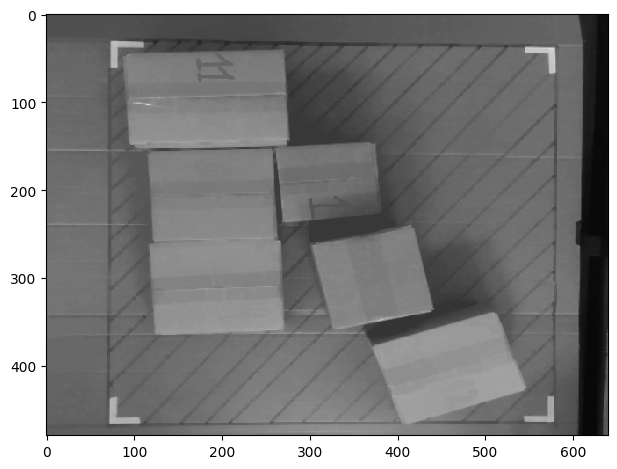

In [26]:
import matplotlib.pyplot as plt
from skimage.morphology import diameter_closing
import numpy as np
from skimage.morphology import closing
from skimage.morphology import square


image = color.rgb2gray(skimage.io.imread("/Users/dudberoll/PycharmProjects/GaprixCV/depth_005_Color_cropped.png"))

closed_attr = diameter_closing(image, 127, connectivity=2)
skimage.io.imshow(closed_attr)

closed = closing(closed_attr, square(3))

closed_uint8 = (closed * 255).astype(np.uint8)
# Сохранение закрытого изображения
save_path = 'depth_005_gray_morphology.png'
skimage.io.imsave(save_path, closed_uint8)

skimage.io.imshow(closed)

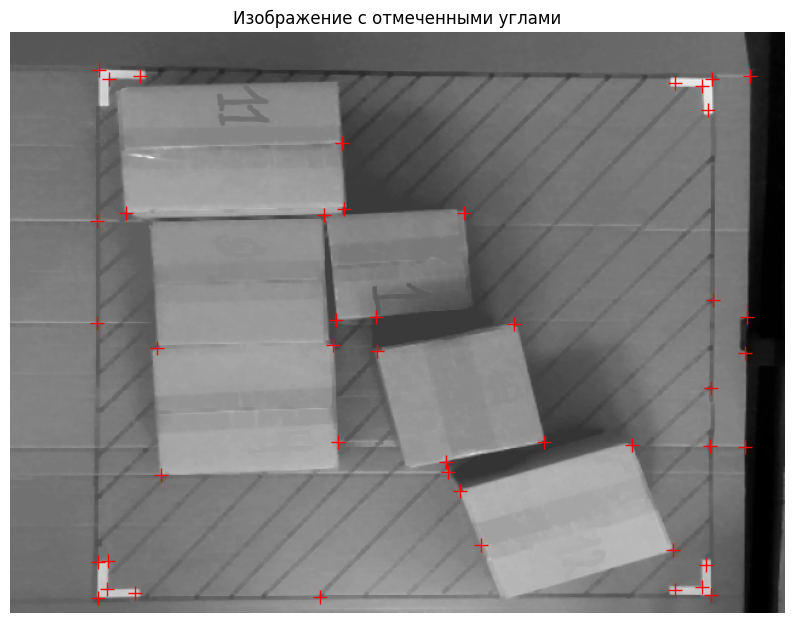

In [8]:
import skimage.io
import skimage.color
from skimage.feature import corner_harris, corner_subpix, corner_peaks

# Загрузка изображения и преобразование в оттенки серого
image_path = "/Users/dudberoll/PycharmProjects/GaprixCV/depth_005_gray_morphology.png"
gray_image = skimage.io.imread(image_path)
# gray_image = skimage.color.rgb2gray(image)

# Нахождение углов с использованием метода Харриса
harris_response = corner_harris(gray_image)
corners = corner_peaks(harris_response, min_distance=5, threshold_rel=0.01)

# Уточнение координат углов с помощью subpix
corners_subpix = corner_subpix(gray_image, corners, window_size=13)

# Отображение изображения с отмеченными углами
plt.figure(figsize=(10, 8))
plt.imshow(image, cmap='gray')
plt.plot(corners_subpix[:, 1], corners_subpix[:, 0], 'r+', markersize=10)
plt.title('Изображение с отмеченными углами')
plt.axis('off')
plt.show()


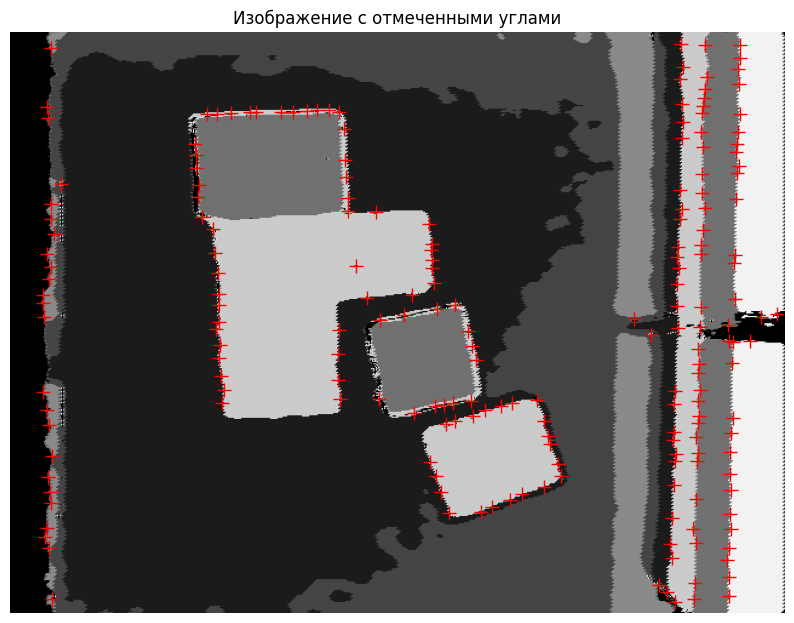

In [6]:
import skimage.io
import skimage.color
from skimage.feature import corner_harris, corner_subpix, corner_peaks

# Загрузка изображения и преобразование в оттенки серого
image_path = "/Users/dudberoll/PycharmProjects/GaprixCV/segmented_image_005_kmeans.png"
gray_image = skimage.io.imread(image_path)
# gray_image = skimage.color.rgb2gray(image)

# Нахождение углов с использованием метода Харриса
harris_response = corner_harris(gray_image)
corners = corner_peaks(harris_response, min_distance=5, threshold_rel=0.01)

# Уточнение координат углов с помощью subpix
corners_subpix = corner_subpix(gray_image, corners, window_size=13)

# Отображение изображения с отмеченными углами
plt.figure(figsize=(10, 8))
plt.imshow(gray_image, cmap='gray')
plt.plot(corners_subpix[:, 1], corners_subpix[:, 0], 'r+', markersize=10)
plt.title('Изображение с отмеченными углами')
plt.axis('off')
plt.show()

In [ ]:
from skimage.feature import local_binary_pattern
from skimage import data
from skimage.color import label2rgb

# settings for LBP
radius = 3
n_points = 8 * radius


def overlay_labels(image, lbp, labels):
    mask = np.logical_or.reduce([lbp == each for each in labels])
    return label2rgb(mask, image=image, bg_label=0, alpha=0.5)


def highlight_bars(bars, indexes):
    for i in indexes:
        bars[i].set_facecolor('r')


image = data.brick()
lbp = local_binary_pattern(image, n_points, radius, METHOD)


def hist(ax, lbp):
    n_bins = int(lbp.max() + 1)
    return ax.hist(
        lbp.ravel(), density=True, bins=n_bins, range=(0, n_bins), facecolor='0.5'
    )


# plot histograms of LBP of textures
fig, (ax_img, ax_hist) = plt.subplots(nrows=2, ncols=3, figsize=(9, 6))
plt.gray()

titles = ('edge', 'flat', 'corner')
w = width = radius - 1
edge_labels = range(n_points // 2 - w, n_points // 2 + w + 1)
flat_labels = list(range(0, w + 1)) + list(range(n_points - w, n_points + 2))
i_14 = n_points // 4  # 1/4th of the histogram
i_34 = 3 * (n_points // 4)  # 3/4th of the histogram
corner_labels = list(range(i_14 - w, i_14 + w + 1)) + list(
    range(i_34 - w, i_34 + w + 1)
)

label_sets = (edge_labels, flat_labels, corner_labels)

for ax, labels in zip(ax_img, label_sets):
    ax.imshow(overlay_labels(image, lbp, labels))

for ax, labels, name in zip(ax_hist, label_sets, titles):
    counts, _, bars = hist(ax, lbp)
    highlight_bars(bars, labels)
    ax.set_ylim(top=np.max(counts[:-1]))
    ax.set_xlim(right=n_points + 2)
    ax.set_title(name)

ax_hist[0].set_ylabel('Percentage')
for ax in ax_img:
    ax.axis('off')

In [ ]:
import skimage.io
from skimage.segmentation import slic, mark_boundaries
import skimage.util
from skimage.morphology import closing, opening, square
import matplotlib.pyplot as plt
import numpy as np

# Чтение изображения
img = skimage.io.imread("/Users/dudberoll/PycharmProjects/GaprixCV/original.png")

# Применение SLIC сегментации
segments_slic = slic(img, n_segments=150, compactness=10, sigma=3, start_label=1)

# Отрисовка границ сегментов на изображении
img_with_boundaries = mark_boundaries(img, segments_slic, (245/255, 0, 0))

# Преобразование изображения в формат uint8
img_with_boundaries = skimage.util.img_as_ubyte(img_with_boundaries)

# Применение морфологического закрытия и открытия для выпрямления линий к каждому каналу
selem = square(3)
img_morphed = np.zeros_like(img_with_boundaries)
for i in range(3):  # Для каждого цветового канала (R, G, B)
    img_morphed[..., i] = closing(opening(img_with_boundaries[..., i], selem), selem)

# Отображение изображений до и после морфологической обработки
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(img_with_boundaries)
ax[0].set_title('До морфологической обработки')
ax[1].imshow(img_morphed)
ax[1].set_title('После морфологической обработки')
for a in ax:
    a.axis('off')
plt.show()

# Сохранение изображения с выпрямленными линиями
# skimage.io.imsave("/Users/dudberoll/PycharmProjects/GaprixCV/original_segmented_morphed.png", img_morphed)


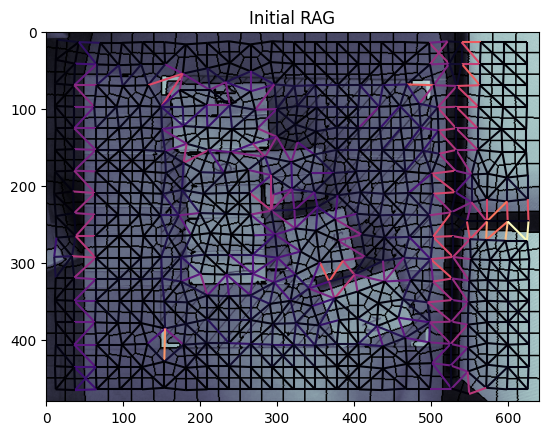

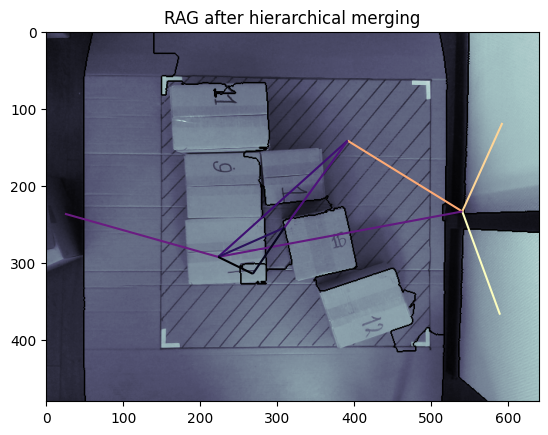

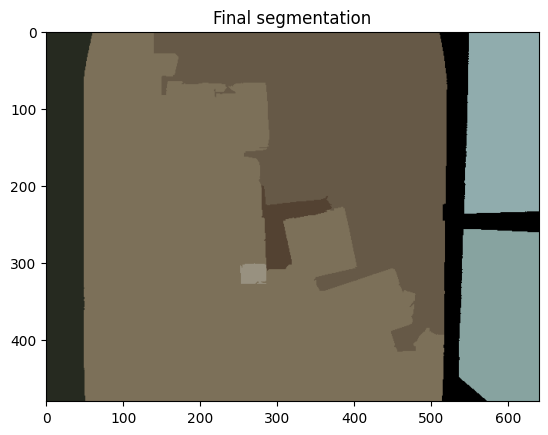

In [6]:
# from skimage import data, segmentation, filters, color
# from skimage import graph
# from matplotlib import pyplot as plt
# 
# 
# def weight_boundary(graph, src, dst, n):
#     """
#     Handle merging of nodes of a region boundary region adjacency graph.
# 
#     This function computes the `"weight"` and the count `"count"`
#     attributes of the edge between `n` and the node formed after
#     merging `src` and `dst`.
# 
# 
#     Parameters
#     ----------
#     graph : RAG
#         The graph under consideration.
#     src, dst : int
#         The vertices in `graph` to be merged.
#     n : int
#         A neighbor of `src` or `dst` or both.
# 
#     Returns
#     -------
#     data : dict
#         A dictionary with the "weight" and "count" attributes to be
#         assigned for the merged node.
# 
#     """
#     default = {'weight': 0.0, 'count': 0}
# 
#     count_src = graph[src].get(n, default)['count']
#     count_dst = graph[dst].get(n, default)['count']
# 
#     weight_src = graph[src].get(n, default)['weight']
#     weight_dst = graph[dst].get(n, default)['weight']
# 
#     count = count_src + count_dst
#     return {
#         'count': count,
#         'weight': (count_src * weight_src + count_dst * weight_dst) / count,
#     }
# 
# 
# def merge_boundary(graph, src, dst):
#     """Call back called before merging 2 nodes.
# 
#     In this case we don't need to do any computation here.
#     """
#     pass
# 
# img = skimage.io.imread("/Users/dudberoll/PycharmProjects/GaprixCV/data/depth_005_Color.png")
# edges = filters.sobel(color.rgb2gray(img))
# labels = segmentation.slic(img, compactness=30, n_segments=400, start_label=1)
# g = graph.rag_boundary(labels, edges)
# 
# graph.show_rag(labels, g, img)
# plt.title('Initial RAG')
# 
# labels2 = graph.merge_hierarchical(
#     labels,
#     g,
#     thresh=0.08,
#     rag_copy=False,
#     in_place_merge=True,
#     merge_func=merge_boundary,
#     weight_func=weight_boundary,
# )
# 
# graph.show_rag(labels, g, img)
# plt.title('RAG after hierarchical merging')
# 
# plt.figure()
# out = color.label2rgb(labels2, img, kind='avg', bg_label=0)
# plt.imshow(out)
# plt.title('Final segmentation')
# 
# plt.show()


In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# 
# from skimage.filters import sobel
# from skimage.measure import label
# from skimage.segmentation import slic, join_segmentations, watershed
# from skimage.color import label2rgb
# from skimage import data
# coins = skimage.io.imread("/Users/dudberoll/PycharmProjects/GaprixCV/data/depth_005_Color.png")
# coins = rgb2gray(coins)
# # Make segmentation using edge-detection and watershed.
# edges = sobel(coins)
# 
# # Identify some background and foreground pixels from the intensity values.
# # These pixels are used as seeds for watershed.
# markers = np.zeros_like(coins)
# foreground, background = 1, 2
# markers[coins < 100.0] = background
# markers[coins > 150.0] = foreground
# 
# ws = watershed(edges, markers)
# seg1 = label(ws == foreground)
# 
# # Make segmentation using SLIC superpixels.
# seg2 = slic(
#     coins,
#     n_segments=117,
#     max_num_iter=160,
#     sigma=1,
#     compactness=0.75,
#     channel_axis=None,
#     start_label=0,
# )
# 
# # Combine the two.
# segj = join_segmentations(seg1, seg2)
# 
# # Show the segmentations.
# fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(9, 5), sharex=True, sharey=True)
# ax = axes.ravel()
# ax[0].imshow(coins, cmap='gray')
# ax[0].set_title('Image')
# 
# color1 = label2rgb(seg1, image=coins, bg_label=0)
# ax[1].imshow(color1)
# ax[1].set_title('Sobel+Watershed')
# 
# color2 = label2rgb(seg2, image=coins, image_alpha=0.5, bg_label=-1)
# ax[2].imshow(color2)
# ax[2].set_title('SLIC superpixels')
# 
# color3 = label2rgb(segj, image=coins, image_alpha=0.5, bg_label=-1)
# ax[3].imshow(color3)
# ax[3].set_title('Join')
# 
# for a in ax:
#     a.axis('off')
# fig.tight_layout()
# plt.show()

KeyboardInterrupt: 

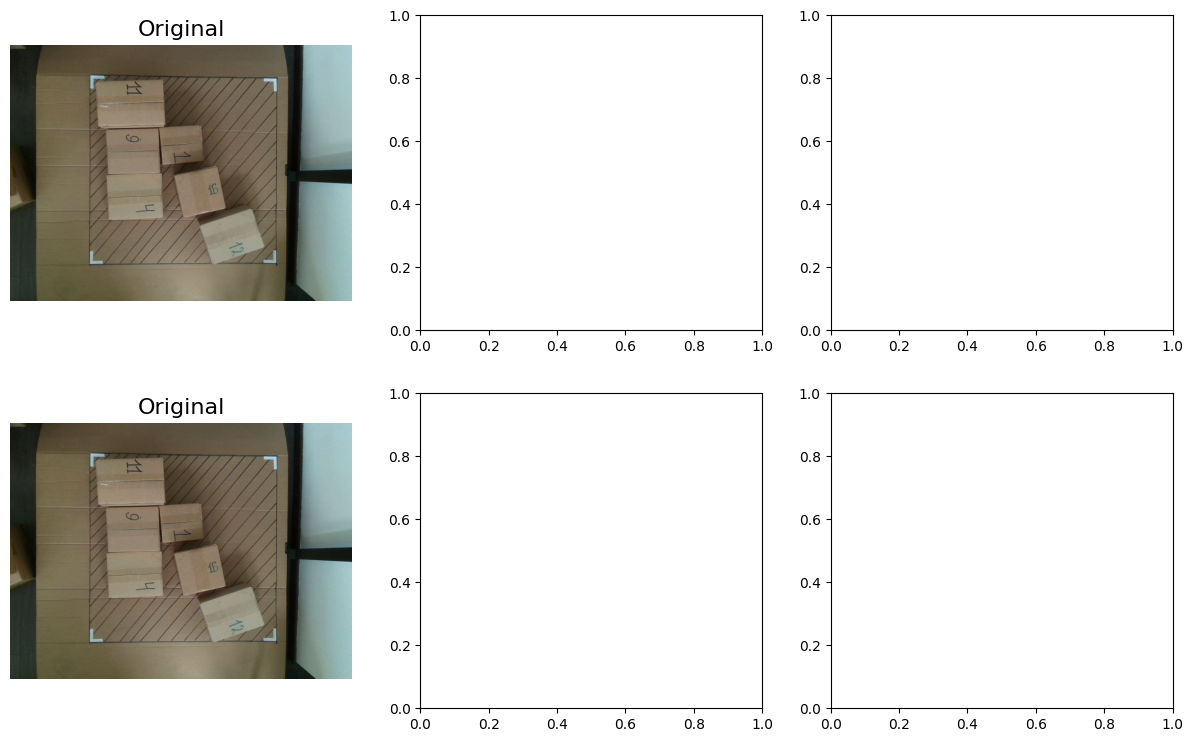

In [4]:
# import matplotlib.pyplot as plt
# from skimage.morphology import diameter_closing
# import skimage
# 
# from skimage import data
# from skimage.morphology import closing
# from skimage.morphology import square
# 
# datasets = {
#     'retina': {
#         'image': skimage.io.imread("/Users/dudberoll/PycharmProjects/GaprixCV/data/depth_005_Color.png"),
#         'figsize': (15, 9),
#         'diameter': 10,
#         'vis_factor': 3,
#         'title': 'Detection of microaneurysm',
#     },
#     'page': {
#         'image': skimage.io.imread("/Users/dudberoll/PycharmProjects/GaprixCV/data/depth_005_Color.png"),
#         'figsize': (15, 7),
#         'diameter': 23,
#         'vis_factor': 1,
#         'title': 'Text detection',
#     },
# }
# 
# for dataset in datasets.values():
#     # image with printed letters
#     image = dataset['image']
#     figsize = dataset['figsize']
#     diameter = dataset['diameter']
# 
#     fig, ax = plt.subplots(2, 3, figsize=figsize)
#     # Original image
#     ax[0, 0].imshow(image, cmap='gray', aspect='equal', vmin=0, vmax=255)
#     ax[0, 0].set_title('Original', fontsize=16)
#     ax[0, 0].axis('off')
# 
#     ax[1, 0].set_title('Original', fontsize=16)
#     ax[1, 0].axis('off')
#     ax[1, 0].imshow(image, cmap='gray', aspect='equal', vmin=0, vmax=255)
# 
#     # Diameter closing : we remove all dark structures with a maximal
#     # extension of less than <diameter> (12 or 23). I.e. in closed_attr, all
#     # local minima have at least a maximal extension of <diameter>.
#     closed_attr = diameter_closing(image, diameter, connectivity=2)
# 
#     # We then calculate the difference to the original image.
#     tophat_attr = closed_attr - image
# 
#     ax[0, 1].imshow(closed_attr, cmap='gray', aspect='equal', vmin=0, vmax=255)
#     ax[0, 1].set_title('Diameter Closing', fontsize=16)
#     ax[0, 1].axis('off')
# 
#     ax[0, 2].imshow(
#         dataset['vis_factor'] * tophat_attr,
#         cmap='gray',
#         aspect='equal',
#         vmin=0,
#         vmax=255,
#     )
#     ax[0, 2].set_title('Tophat (Difference)', fontsize=16)
#     ax[0, 2].axis('off')
# 
#     # A morphological closing removes all dark structures that cannot
#     # contain a structuring element of a certain size.
#     closed = closing(image, square(diameter))
# 
#     # Again we calculate the difference to the original image.
#     tophat = closed - image
# 
#     ax[1, 1].imshow(closed, cmap='gray', aspect='equal', vmin=0, vmax=255)
#     ax[1, 1].set_title('Morphological Closing', fontsize=16)
#     ax[1, 1].axis('off')
# 
#     ax[1, 2].imshow(
#         dataset['vis_factor'] * tophat, cmap='gray', aspect='equal', vmin=0, vmax=255
#     )
#     ax[1, 2].set_title('Tophat (Difference)', fontsize=16)
#     ax[1, 2].axis('off')
#     fig.suptitle(dataset['title'], fontsize=18)
#     fig.tight_layout(rect=(0, 0, 1, 0.88))
# 
# plt.show()

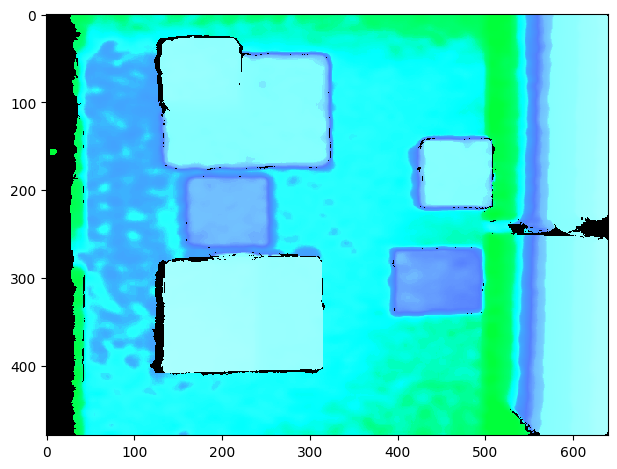

In [25]:
import cv2
import skimage
# mg1 = cv2.imread("/Users/dudberoll/PycharmProjects/GaprixCV/data/depth_005_Color.jpg")
mg = skimage.io.imread("/Users/dudberoll/PycharmProjects/GaprixCV/data/depth_011_Depth.png")
mg = skimage.color.rgb2hsv(mg)
skimage.io.imshow(mg)
# cv2.imshow('dlf', mg1)
# cv2.waitKey(0)

In [ ]:
это хуй знает вообще зачем

In [13]:
def point_cloud(depth):
    rows, cols = depth.shape
    c, r = np.meshgrid(np.arange(cols), np.arange(rows), sparse=True)
    valid = (depth > 0) & (depth < 255)
    z = np.where(valid, depth / 256.0, np.nan)
    x = np.where(valid, z * (c - 0) / .05, 0)
    y = np.where(valid, z * (r - 1) / .05, 0)
    return np.dstack((x, y, z))

img = cv2.imread('/Users/dudberoll/PycharmProjects/GaprixCV/data/depth_005_Depth.png',  cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)
img = img[:,:,1]
points = point_cloud(img)


In [ ]:
хуйня эта бинаризация ниблека

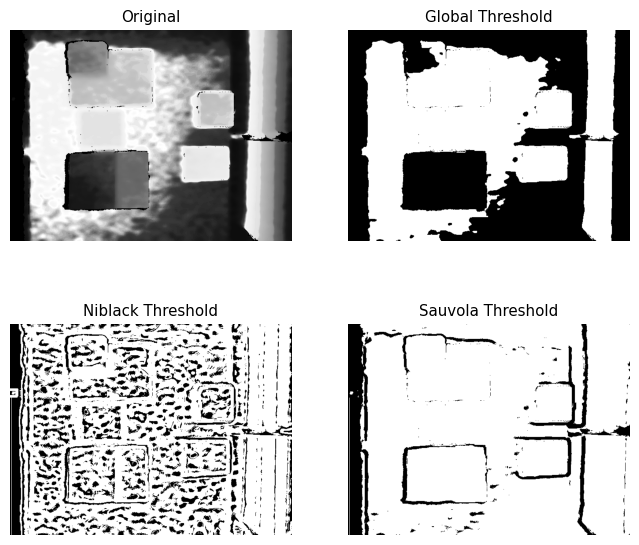

In [32]:
import matplotlib
import matplotlib.pyplot as plt

from skimage.data import page
from skimage.filters import threshold_otsu, threshold_niblack, threshold_sauvola


matplotlib.rcParams['font.size'] = 9


imag = skimage.io.imread("/Users/dudberoll/PycharmProjects/GaprixCV/data/depth_011_Depth.png")
image = rgb2gray(imag)

binary_global = image > threshold_otsu(image)

window_size = 15
thresh_niblack = threshold_niblack(image, window_size=window_size, k=0.5)
thresh_sauvola = threshold_sauvola(image, window_size=window_size)

binary_niblack = image > thresh_niblack
binary_sauvola = image > thresh_sauvola

plt.figure(figsize=(8, 7))
plt.subplot(2, 2, 1)
plt.imshow(image, cmap=plt.cm.gray)
plt.title('Original')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.title('Global Threshold')
plt.imshow(binary_global, cmap=plt.cm.gray)
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(binary_niblack, cmap=plt.cm.gray)
plt.title('Niblack Threshold')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(binary_sauvola, cmap=plt.cm.gray)
plt.title('Sauvola Threshold')
plt.axis('off')

plt.show()

Contour Area: 229871.38056724425


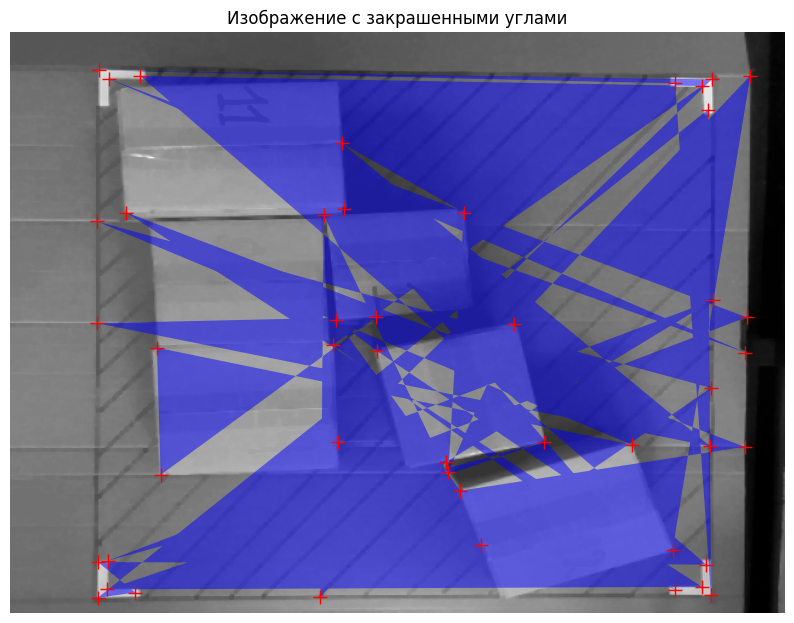

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import skimage
from skimage.color import rgb2gray
from skimage.feature import corner_harris, corner_subpix, corner_peaks
from scipy.spatial import ConvexHull

# Загрузка изображения
image_path = "/Users/dudberoll/PycharmProjects/GaprixCV/depth_005_gray_morphology.png"
gray_image = skimage.io.imread(image_path)
image = skimage.io.imread(image_path)

# Нахождение углов с использованием метода Харриса
harris_response = corner_harris(gray_image)
corners = corner_peaks(harris_response, min_distance=5, threshold_rel=0.01)

# Уточнение координат углов с помощью subpix
corners_subpix = corner_subpix(gray_image, corners, window_size=13)

# Подготовка координат для закраски
if corners_subpix is not None:
    x = corners_subpix[:, 1]
    y = corners_subpix[:, 0]
else:
    x = corners[:, 1]
    y = corners[:, 0]

# Удаление NaN значений из координат
valid_indices = ~np.isnan(x) & ~np.isnan(y)
x = x[valid_indices]
y = y[valid_indices]

# Сортировка точек, если необходимо (например, по углу относительно центра)
center = np.mean(np.vstack((x, y)).T, axis=0)
angles = np.arctan2(y - center[0], x - center[1])
sort_order = np.argsort(angles)
x_sorted = x[sort_order]
y_sorted = y[sort_order]
x_sorted = x
y_sorted = y
# Вычисление площади контура (contour area)
points = np.vstack((x_sorted, y_sorted)).T
hull = ConvexHull(points)
contour_area = hull.volume  # Для 2D ConvexHull, volume дает площадь

print(f"Contour Area: {contour_area}")

# Отображение изображения с закрашенными углами
plt.figure(figsize=(10, 8))
plt.imshow(image, cmap='gray')
plt.plot(x_sorted, y_sorted, 'r+', markersize=10)
plt.fill(x_sorted, y_sorted, 'b', alpha=0.5)  # Закраска многоугольника
plt.title('Изображение с закрашенными углами')
plt.axis('off')
plt.show()


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import skimage
from skimage.color import rgb2gray
from skimage.feature import corner_harris, corner_subpix, corner_peaks
from skimage.io import imread
from scipy.spatial import ConvexHull

# Загрузка изображения и маски
image_path = "/Users/dudberoll/PycharmProjects/GaprixCV/depth_005_gray_morphology.png"
mask_path = "/Users/dudberoll/PycharmProjects/GaprixCV/depth_005_Color_Mask_cropped.png"

gray_image = imread(image_path)
# gray_image = rgb2gray(image)
mask = imread(mask_path)

# Нахождение углов с использованием метода Харриса
harris_response = corner_harris(gray_image)
corners = corner_peaks(harris_response, min_distance=5, threshold_rel=0.02)

# Уточнение координат углов с помощью subpix
corners_subpix = corner_subpix(gray_image, corners, window_size=13)

# Подготовка координат для закраски
if corners_subpix is not None:
    x = corners_subpix[:, 1]
    y = corners_subpix[:, 0]
else:
    x = corners[:, 1]
    y = corners[:, 0]

# Фильтрация углов по маске
filtered_corners = []
for (i, j) in zip(y, x):
    if np.any(mask[int(i), int(j)]):
        filtered_corners.append((i, j))

filtered_corners = np.array(filtered_corners)
if len(filtered_corners) == 0:
    raise ValueError("Нет углов, соответствующих маске.")

# Разделение координат на x и y
x_filtered = filtered_corners[:, 1]
y_filtered = filtered_corners[:, 0]

# Сортировка точек преимущественно по вертикали и горизонтали
sorted_indices = np.lexsort((x_filtered, y_filtered))
x_sorted = x_filtered[sorted_indices]
y_sorted = y_filtered[sorted_indices]

# Рисование и закраска области между точками
plt.figure(figsize=(10, 8))
plt.imshow(gray_image, cmap='gray')
plt.plot(x_sorted, y_sorted, 'r+', markersize=10)

# Соединение точек линиями
for i in range(len(x_sorted) - 1):
    plt.plot([x_sorted[i], x_sorted[i+1]], [y_sorted[i], y_sorted[i+1]], 'r-')

# Закраска многоугольника
plt.fill(x_sorted, y_sorted, 'b', alpha=0.3)

plt.title('Изображение с закрашенными углами')
plt.axis('off')
plt.show()


ValueError: cannot convert float NaN to integer

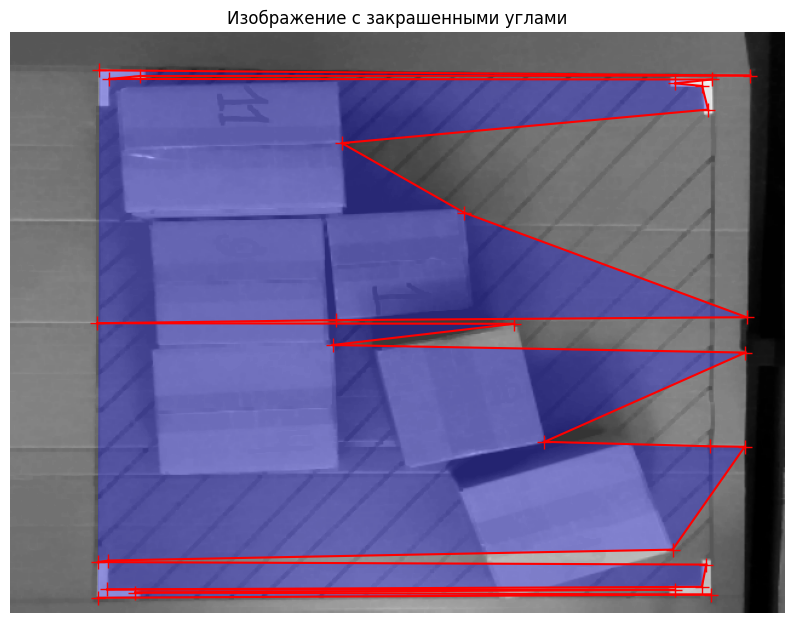

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, feature

# Загрузка изображения и маски
image_path = "/Users/dudberoll/PycharmProjects/GaprixCV/depth_005_gray_morphology.png"
mask_path = "/Users/dudberoll/PycharmProjects/GaprixCV/depth_005_Color_Mask_cropped.png"

# Загрузка изображения и конвертация в градации серого
image = io.imread(image_path)
if image.ndim == 3 and image.shape[2] == 3:
    gray_image = color.rgb2gray(image)
else:
    gray_image = image

# Загрузка и бинаризация маски
mask = io.imread(mask_path)


# Нахождение углов с использованием метода Харриса
harris_response = feature.corner_harris(gray_image)
corners = feature.corner_peaks(harris_response, min_distance=5, threshold_rel=0.02)

# Уточнение координат углов с помощью subpix
corners_subpix = feature.corner_subpix(gray_image, corners, window_size=13)

# Подготовка координат для закраски
if corners_subpix is not None:
    x = corners_subpix[:, 1]
    y = corners_subpix[:, 0]
else:
    x = corners[:, 1]
    y = corners[:, 0]

valid_indices = ~np.isnan(x) & ~np.isnan(y)
x = x[valid_indices]
y = y[valid_indices]
# Фильтрация углов по маске
filtered_corners = []
for (i, j) in zip(y, x):
    if mask[int(i), int(j)]:
        filtered_corners.append((i, j))

filtered_corners = np.array(filtered_corners)
if len(filtered_corners) == 0:
    raise ValueError("Нет углов, соответствующих маске.")

# Разделение координат на x и y
x_filtered = filtered_corners[:, 1]
y_filtered = filtered_corners[:, 0]


# Сортировка точек преимущественно по вертикали и горизонтали
sorted_indices = np.lexsort((x_filtered, y_filtered))
x_sorted = x_filtered[sorted_indices]
y_sorted = y_filtered[sorted_indices]

# Рисование и закраска области между точками
plt.figure(figsize=(10, 8))
plt.imshow(gray_image, cmap='gray')
plt.plot(x_sorted, y_sorted, 'r+', markersize=10)

# Соединение точек линиями
for i in range(len(x_sorted) - 1):
    plt.plot([x_sorted[i], x_sorted[i+1]], [y_sorted[i], y_sorted[i+1]], 'r-')

# Закраска многоугольника
plt.fill(x_sorted, y_sorted, 'b', alpha=0.3)

plt.title('Изображение с закрашенными углами')
plt.axis('off')
plt.show()


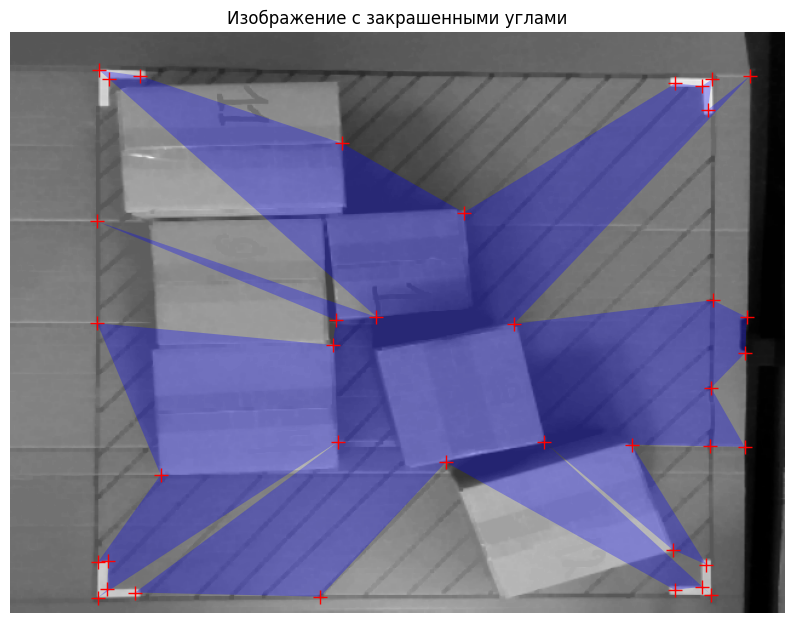

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, feature

# Загрузка изображения и маски
image_path = "/Users/dudberoll/PycharmProjects/GaprixCV/depth_005_gray_morphology.png"
mask_path = "/Users/dudberoll/PycharmProjects/GaprixCV/depth_005_Color_Mask_cropped.png"
# Загрузка изображения и конвертация в градации серого
image = io.imread(image_path)
if image.ndim == 3 and image.shape[2] == 3:
    gray_image = color.rgb2gray(image)
else:
    gray_image = image

# Загрузка и бинаризация маски
mask = io.imread(mask_path)
mask = mask > 128  # Бинаризация маски

# Нахождение углов с использованием метода Харриса
harris_response = feature.corner_harris(gray_image)
corners = feature.corner_peaks(harris_response, min_distance=5, threshold_rel=0.01)

# Уточнение координат углов с помощью subpix
corners_subpix = feature.corner_subpix(gray_image, corners, window_size=13)

# Подготовка координат для закраски
if corners_subpix is not None:
    x = corners_subpix[:, 1]
    y = corners_subpix[:, 0]
else:
    x = corners[:, 1]
    y = corners[:, 0]

# Исключение NaN значений
valid_indices = ~np.isnan(x) & ~np.isnan(y)
x = x[valid_indices]
y = y[valid_indices]

# Фильтрация углов по маске
filtered_corners = []
for (i, j) in zip(y, x):
    if mask[int(i), int(j)]:
        filtered_corners.append((i, j))

filtered_corners = np.array(filtered_corners)
if len(filtered_corners) == 0:
    raise ValueError("Нет углов, соответствующих маске.")

# Разделение координат на x и y
x_filtered = filtered_corners[:, 1]
y_filtered = filtered_corners[:, 0]

# Сортировка точек для построения многоугольника (сортировка по углу относительно центра)
center = np.mean(filtered_corners, axis=0)
angles = np.arctan2(y_filtered - center[0], x_filtered - center[1])
sort_order = np.argsort(angles)
x_sorted = x_filtered[sort_order]
y_sorted = y_filtered[sort_order]

# Рисование и закраска области между точками
plt.figure(figsize=(10, 8))
plt.imshow(gray_image, cmap='gray')
plt.plot(x_sorted, y_sorted, 'r+', markersize=10)

# Соединение точек линиями и закраска многоугольника
plt.fill(x_sorted, y_sorted, 'b', alpha=0.3)

plt.title('Изображение с закрашенными углами')
plt.axis('off')
plt.show()
